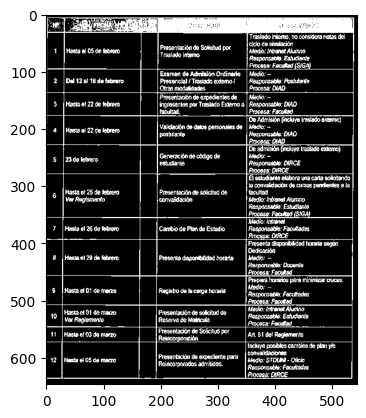

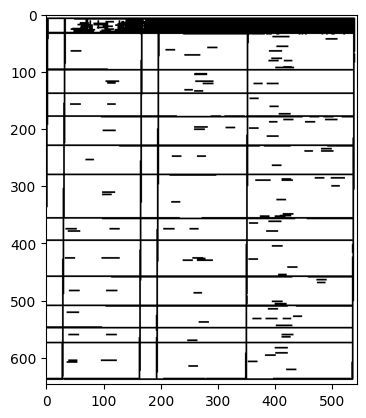

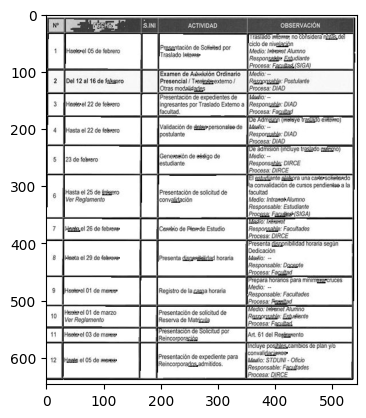

        0                                    1 2
0                                               
1                                               
2                                               
3                                               
4                                               
5                                               
6                                               
7                                               
8                                               
9                                       Leases  
10         Heserel 01 de marzo\nVer Reglamento  
11                        Heetrel 03 de maze i  
12  penne                                       
| 0 | 1 | 2 |
| --- | --- | --- |
|  |  |  |
|  |  |  |
|  |  |  |
|  |  |  |
|  |  |  |
|  |  |  |
|  |  |  |
|  |  |  |
|  |  |  |
|  | Leases |  |
|  | Heserel 01 de marzo
Ver Reglamento |  |
|  | Heetrel 03 de maze i |  |
| penne |  |  |



In [2]:
import cv2
import numpy as np
import pytesseract
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# Asegúrate de que pytesseract sepa dónde está el ejecutable de Tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

# Leer la imagen
file = r'C:\xampp\htdocs\php5\content\Proyecto\imagen-tabla.JPG'  # Cambia la ruta a tu imagen
img = cv2.imread(file, 0)

# Umbralizar la imagen a una imagen binaria
_, img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# Invertir la imagen
img_bin = 255 - img_bin

# Mostrar la imagen binaria invertida
plt.imshow(img_bin, cmap='gray')
plt.show()

# Detección de líneas verticales y horizontales
kernel_len = np.array(img).shape[1] // 100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

# Detectar líneas verticales
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

# Detectar líneas horizontales
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

# Combinamos las líneas horizontales y verticales
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
_, img_vh = cv2.threshold(img_vh, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# Visualización de la imagen combinada
plt.imshow(img_vh, cmap='gray')
plt.show()

# Aplicar XOR a la imagen original y la imagen de líneas
bitxor = cv2.bitwise_xor(img, img_vh)
bitnot = cv2.bitwise_not(bitxor)

# Visualización de la imagen resultante tras XOR
plt.imshow(bitnot, cmap='gray')
plt.show()

# Encontrar los contornos en la imagen procesada
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Ordenar los contornos de arriba a abajo
def sort_contours(cnts, method="top-to-bottom"):
    i = 1
    reverse = False
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)

# Ordenar contornos
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

# Crear una lista para almacenar las cajas
box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if w > 80 and h > 20:  # Ajustar estos valores según sea necesario
        box.append((x, y, w, h))

# Organizar las cajas en filas y columnas
row = []
column = []
j = 0
mean = np.mean([boundingBoxes[i][3] for i in range(len(boundingBoxes))])  # Altura media

for i in range(len(box)):
    if i == 0:
        column.append(box[i])
        previous = box[i]
    else:
        if box[i][1] <= previous[1] + mean / 2:
            column.append(box[i])
            previous = box[i]
            if i == len(box) - 1:
                row.append(column)
        else:
            row.append(column)
            column = []
            previous = box[i]
            column.append(box[i])

# Detectar el número máximo de columnas
countcol = max([len(r) for r in row])

# Encontrar el centro de cada celda
center = []
for i in range(len(row)):
    for j in range(len(row[i])):
        center_value = row[i][j][0] + row[i][j][2] // 2
        center.append(center_value)

center = np.array(center)
center.sort()

# Ajustar las cajas según las columnas detectadas
finalboxes = []
for i in range(len(row)):
    lis = [[] for _ in range(countcol)]  # Corregido: inicializar con listas vacías para cada columna
    for j in range(len(row[i])):
        diff = abs(center - (row[i][j][0] + row[i][j][2] // 2))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        if indexing < countcol:  # Verificar que no accedemos fuera del rango
            lis[indexing].append(row[i][j])
    finalboxes.append(lis)

# Extraer el texto de cada celda usando pytesseract
outer = []
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner = ''
        if len(finalboxes[i][j]) == 0:
            outer.append('')
        else:
            for k in range(len(finalboxes[i][j])):
                y, x, w, h = finalboxes[i][j][k]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=[255, 255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel, iterations=1)
                erosion = cv2.erode(dilation, kernel, iterations=2)

                out = pytesseract.image_to_string(erosion, config='--psm 6')  # Usamos --psm 6 para tablas
                inner += " " + out.strip()
            outer.append(inner.strip())

# Crear un DataFrame de los datos extraídos
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row), countcol))

# Mostrar el DataFrame extraído
print(dataframe)

# Convertir el DataFrame a formato Markdown
def dataframe_to_markdown(df):
    # Convertir los nombres de las columnas a cadenas de texto
    markdown = "| " + " | ".join(map(str, df.columns)) + " |\n"
    markdown += "| " + " | ".join("---" for _ in df.columns) + " |\n"
    
    # Iterar sobre las filas y convertir los valores a cadenas
    for index, row in df.iterrows():
        markdown += "| " + " | ".join(map(str, row)) + " |\n"
    
    return markdown

# Convertir el DataFrame a Markdown
markdown_tabla = dataframe_to_markdown(dataframe)

# Guardar la tabla en formato Markdown
with open("tabla_extraida.md", "w", encoding="utf-8") as file:
    file.write(markdown_tabla)

# Mostrar la tabla en formato Markdown
print(markdown_tabla)

